# Humor Detection in Online Product Questions
---------

*First data science project done my Mattison Hineline* 

An introductory project to determine humor in online product questions using NLP.

_______

## Data Location and Registry

https://registry.opendata.aws/humor-detection/

The dataset contains 3 csv file where each row corresponds to a product question.
1. Humorous.csv - contains the humorous product questions, link for direct download - https://humor-detection-pds.s3-us-west-2.amazonaws.com/Humorous.csv
2. Non-humorous-unbiased.csv - contains the non-humorous prodcut questions, from the same products as the humorous one, link for direct download -  https://humor-detection-pds.s3-us-west-2.amazonaws.com/Non-humorous-unbiased.csv
3. Non-humorous-biased.csv - contains the non-humorous prodcut questions, from randomly selected products, link for direct download -  https://humor-detection-pds.s3-us-west-2.amazonaws.com/Non-humours-biased.csv

All files have the same structure

The columns are:
- question: the question text
- product_description: short description of the product.
- image_url: url for the prodcut image.
- label: 1 if the product question is humorous, 0 otherwise.

Data set links:
- https://humor-detection-pds.s3-us-west-2.amazonaws.com/Humorous.csv
- https://humor-detection-pds.s3-us-west-2.amazonaws.com/Non-humorous-unbiased.csv
- https://humor-detection-pds.s3-us-west-2.amazonaws.com/Non-humours-biased.csv

______

## Import Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#work with text 
import re
from textblob import TextBlob
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import enchant
import splitter
from manual_spellchecker import spell_checker
from nltk.sentiment import SentimentIntensityAnalyzer

#modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
from sklearn.preprocessing import StandardScaler


-----
## Import Data and Initial Look

In [2]:
#import dataset
humorous = pd.read_csv('https://humor-detection-pds.s3-us-west-2.amazonaws.com/Humorous.csv')
non_humorous_unbiased = pd.read_csv('https://humor-detection-pds.s3-us-west-2.amazonaws.com/Non-humorous-unbiased.csv')

In [3]:
print('humorous')
humorous.head()

humorous


,question,product_description,image_url,label
0,Will the volca sample get me a girlfriend?,Korg Amplifier Part VOLCASAMPLE,http://ecx.images-amazon.com/images/I/81I1XZea...,1
1,Can u communicate with spirits even on Saturday?,Winning Moves Games Classic Ouija,http://ecx.images-amazon.com/images/I/81kcYEG5...,1
2,I won't get hunted right?,Winning Moves Games Classic Ouija,http://ecx.images-amazon.com/images/I/81kcYEG5...,1
3,I have a few questions.. Can you get possessed...,Winning Moves Games Classic Ouija,http://ecx.images-amazon.com/images/I/81kcYEG5...,1
4,Has anyone asked where the treasure is? What w...,Winning Moves Games Classic Ouija,http://ecx.images-amazon.com/images/I/81kcYEG5...,1


In [4]:
print('non_humorous_unbiased')
non_humorous_unbiased.head()

non_humorous_unbiased


,question,product_description,image_url,label
0,Is AudioPocket only for iPhone (recording soun...,Korg Amplifier Part VOLCASAMPLE,http://ecx.images-amazon.com/images/I/81I1XZea...,0
1,Standard shipping takes how long?,Winning Moves Games Classic Ouija,http://ecx.images-amazon.com/images/I/81kcYEG5...,0
2,Can I use this my self?,Winning Moves Games Classic Ouija,http://ecx.images-amazon.com/images/I/81kcYEG5...,0
3,If the felt comes off the guide can I return i...,Winning Moves Games Classic Ouija,http://ecx.images-amazon.com/images/I/81kcYEG5...,0
4,Does it acually work?,Winning Moves Games Classic Ouija,http://ecx.images-amazon.com/images/I/81kcYEG5...,0


In [5]:
#inital look at humorous
humorous.describe()
humorous.info()
humorous.columns
humorous['product_description'].isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9571 entries, 0 to 9570
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   question             9571 non-null   object
 1   product_description  9547 non-null   object
 2   image_url            9230 non-null   object
 3   label                9571 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 299.2+ KB


24

#### 'humorous' Dataset

We have no missing values for the question and label columns, which is what we will be focusing on in this project. We have 24 (0.25%) missing values for product_description and 317 (3.31%) missing values for image_url. Since we are unsure if we will use these columns later at this point, we will leave these missing values in the dataset.  

In [6]:
non_humorous_unbiased.describe()
non_humorous_unbiased.info()
non_humorous_unbiased.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9571 entries, 0 to 9570
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   question             9571 non-null   object
 1   product_description  9547 non-null   object
 2   image_url            9230 non-null   object
 3   label                9571 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 299.2+ KB


Index(['question', 'product_description', 'image_url', 'label'], dtype='object')

#### 'non_humorous_unbiased' Dataset
This is the same products as the humorous dataset and therefore we are not surprised when we find the same missing value information as before. 

We have no missing values for the question and label columns, which is what we will be focusing on in this project. We have 24 (0.25%) missing values for product_description and 317 (3.31%) missing values for image_url. Since we are unsure if we will use these columns later at this point, we will leave these missing values in the dataset.  

-----
## Exploratory Analysis

Things to do:
1. convert all letters to lowercase
2. deal with joined and misspelled words (replace punctuation with " ")
3. remove filler and small words (stop words) in 'question'
4. find most common question words - could make a df with common words and count for humor vs. non (word, count humor, count non ---> tokenizing?)
5. plot data to explore 
6. Should we look at the product too? 

First, we will combine the 'humorous_unbiased' (saved as just 'humorous') and 'non_humorous_unbiased' dataframes so that we can work with 1 (humor marker) and 0 (non-humorous marker) all at once. We want both dataset to have the same transformations to result in the best models later.

In [7]:
#combine dataframes
combined_df = pd.concat([humorous, non_humorous_unbiased], ignore_index=True)

Since we have decided we will not be using the image links given, we will delete the image_url columns as they are not pertinent to this project.

In [8]:
#drop image_url column
combined_df.drop(['image_url'], axis=1, inplace=True)

Now we will begin working with the text data. We will need to clean up and make the text easier to work with.

In [9]:
# remove extra spaces and punctuatinon
combined_df['q_no_punctuation'] = combined_df['question'].apply(lambda row: re.sub(r'[^\w\s]+', " ", row))
combined_df['clean'] = combined_df['q_no_punctuation'].apply(lambda row: re.sub(r'\b\w{1,3}\b', '', row))

In [10]:
#remove small words
stop_words = stopwords.words('english')
combined_df['clean'] = combined_df['q_no_punctuation'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# convert all letters to lowercase
combined_df['clean'] = combined_df['clean'].str.lower()

# remove words less than/equal to 3 letters 
combined_df['clean > 3'] = combined_df['clean'].str.replace(r'\b(\w{1,3})\b', '')

<ipython-input-10-bcc0dc2f68c7>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df['clean > 3'] = combined_df['clean'].str.replace(r'\b(\w{1,3})\b', '')


Once we have the text ready, we will then tokenize it to be able to run models on it later, and also to visualize it too.

In [11]:
# define tokenize function
def tokenization(text):
    tokens = re.split('\W+', text)
    return tokens

In [12]:
# run tokenize function
combined_df['tokenized'] = combined_df['clean > 3'].apply(lambda row: tokenization(row))
for row in combined_df['tokenized']:
    for word in row:
        if word == '': 
            row.pop(row.index(word))

Now we have the words split up. We can do processes on the data now. We can lemmatize or stem the data. Lemmatization will keep the meanings of words more them stemming, which will bring each word to its root word. 

In [13]:
# define lemmatizer function
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text): 
    l_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return l_text

In [14]:
# run lemmatizer function
combined_df['lemmatized'] = combined_df['tokenized'].apply(lambda row: lemmatizer(row))

In [15]:
# define stemming function 
porter_stemmer = PorterStemmer()
def stemming(text):
    stemmed = [porter_stemmer.stem(word) for word in text]
    return stemmed

In [16]:
# run stemming function
combined_df['stemmed'] = combined_df['tokenized'].apply(lambda row: stemming(row))

Let's take a look at what we have now

In [17]:
combined_df.head()

,question,product_description,label,q_no_punctuation,clean,clean > 3,tokenized,lemmatized,stemmed
0,Will the volca sample get me a girlfriend?,Korg Amplifier Part VOLCASAMPLE,1,Will the volca sample get me a girlfriend,will volca sample get girlfriend,will volca sample girlfriend,"[will, volca, sample, girlfriend]","[will, volca, sample, girlfriend]","[will, volca, sampl, girlfriend]"
1,Can u communicate with spirits even on Saturday?,Winning Moves Games Classic Ouija,1,Can u communicate with spirits even on Saturday,can u communicate spirits even saturday,communicate spirits even saturday,"[communicate, spirits, even, saturday]","[communicate, spirit, even, saturday]","[commun, spirit, even, saturday]"
2,I won't get hunted right?,Winning Moves Games Classic Ouija,1,I won t get hunted right,i get hunted right,hunted right,"[hunted, right]","[hunted, right]","[hunt, right]"
3,I have a few questions.. Can you get possessed...,Winning Moves Games Classic Ouija,1,I have a few questions Can you get possessed ...,i questions can get possessed can age older 13,questions possessed older,"[questions, possessed, older]","[question, possessed, older]","[question, possess, older]"
4,Has anyone asked where the treasure is? What w...,Winning Moves Games Classic Ouija,1,Has anyone asked where the treasure is What w...,has anyone asked treasure what answer received,anyone asked treasure what answer received,"[anyone, asked, treasure, what, answer, received]","[anyone, asked, treasure, what, answer, received]","[anyon, ask, treasur, what, answer, receiv]"


In [18]:
combined_df.tail()

,question,product_description,label,q_no_punctuation,clean,clean > 3,tokenized,lemmatized,stemmed
19137,Serve na f800r 2013?,Puig 5051F Dark Smoke New Generation Windshield,0,Serve na f800r 2013,serve na f800r 2013,serve f800r 2013,"[serve, f800r, 2013]","[serve, f800r, 2013]","[serv, f800r, 2013]"
19138,Can it run mine sweeper abve 10 fps?,SkyTech Supremacy Gaming Computer PC Desktop -...,0,Can it run mine sweeper abve 10 fps,can run mine sweeper abve 10 fps,mine sweeper abve,"[mine, sweeper, abve]","[mine, sweeper, abve]","[mine, sweeper, abv]"
19139,What is the difference between the pro weight ...,Rapid Tone Ultra Weight Loss Supplement - Extr...,0,What is the difference between the pro weight ...,what difference pro weight loss ultra weight l...,what difference weight loss ultra weight loss...,"[what, difference, weight, loss, ultra, weight...","[what, difference, weight, loss, ultra, weight...","[what, differ, weight, loss, ultra, weight, lo..."
19140,Can you provide me a phone number to the compa...,Essence PH Skin Cream 0.5 fl oz/15ml,0,Can you provide me a phone number to the compa...,can provide phone number company offices essen...,provide phone number company offices essence ...,"[provide, phone, number, company, offices, ess...","[provide, phone, number, company, office, esse...","[provid, phone, number, compani, offic, essenc..."
19141,Is the blenders sponge latex free?,10 Piece Kabuki Contouring Makeup Brush Set wi...,0,Is the blenders sponge latex free,is blenders sponge latex free,blenders sponge latex free,"[blenders, sponge, latex, free]","[blender, sponge, latex, free]","[blender, spong, latex, free]"


We want to make a new dataframe with the most common words. We are doing this to try to remove any noise from the data.

In [19]:
def make_common_word_df(dataframe, start_index, end_index):
    # common words dataframe
    all_words = pd.Series(' '.join(dataframe['clean > 3']).split()).value_counts()
    words_df = pd.DataFrame({'word':all_words.index, 'count':all_words.values})
    rare_words = words_df.loc[words_df['count'] == 1]
    list_rare_words = list(rare_words['word'])

    # make a list of the most common words - this will take a time to iterate through
    analysis_words = []
    for row in range(start_index, end_index):
        for word in dataframe.loc[row]['stemmed']:
            if word == ' ' or word =='':
                pass
            elif word in list_rare_words:
                pass
            elif word.isalpha() == False: 
                pass
            elif word not in analysis_words and len(word)>3: 
                analysis_words.append(word)

    #set count of words as 0 
    analysis_dict = dict()
    for word in analysis_words:
        analysis_dict[word] = 0
    analysis_dict['rare word'] = 0 #words that only appear once in all of the dataframe

    #create dataframe
    for row in range(start_index, end_index):
        for word in dataframe.loc[row]['stemmed']:
            if word not in analysis_dict:
                analysis_dict['rare word'] = analysis_dict['rare word'] + 1
            else:
                analysis_dict[word] = analysis_dict[word] + 1
    final_dict = {}
    for word in analysis_dict:
        if analysis_dict[word] != 1:
            final_dict[word] = analysis_dict[word]

    return pd.DataFrame.from_dict(final_dict, orient='index')


Lets make a humorous words dataframe and a non_humorous words dataframe.

In [20]:
humorous_words = make_common_word_df(combined_df[combined_df['label'] ==1], 0, 9571)
humorous_words.reset_index(inplace=True)
humorous_words.rename(columns={0:'humorous', 'index':'word'}, inplace=True)

In [21]:
non_humorous_words = make_common_word_df(combined_df[combined_df['label'] == 0], 9571, 19141)
non_humorous_words.reset_index(inplace=True)
non_humorous_words.rename(columns={0:'non_humorous', 'index':'word'}, inplace=True)

Let's combine the words dataframe and see how it looks

In [22]:
merged_words_df = pd.merge(humorous_words, non_humorous_words)
merged_words_df

,word,humorous,non_humorous
0,will,1445,405
1,sampl,6,15
2,commun,17,5
3,spirit,59,3
4,even,44,43
...,...,...,...
1804,sanit,2,2
1805,ukulel,2,2
1806,penni,3,2
1807,kitten,3,5


Now we have a dataframe "merged_words_df" which has each row as a common word in stemmed form and the number of humorous and non_humorous occurences. Let's add these a total to the dataframe too.

In [23]:
merged_words_df = merged_words_df.reindex(columns=['word', 'humorous', 'non_humorous'])
merged_words_df['total occurances'] = merged_words_df['humorous'] + merged_words_df['non_humorous']
merged_words_df.head()

,word,humorous,non_humorous,total occurances
0,will,1445,405,1850
1,sampl,6,15,21
2,commun,17,5,22
3,spirit,59,3,62
4,even,44,43,87


In [24]:
merged_words_df.sort_values(by='total occurances', inplace=True, ascending=False)

Lets make a dataframe which has humorous and non-humorous sentences all in the same dataframe. Then we will make the following columns:
- Number of words
- avg. length of words
- sentiment type

In [25]:
#make number of total tokenized words
combined_df['number of words'] = combined_df['tokenized'].apply(lambda row: len(row))

In [26]:
# find average length of words per row
combined_df['avg word length'] = 0.0

for row in range(len(combined_df)):
    count = 0
    if len(combined_df.loc[row]['tokenized']) == 0:
        pass
    else:
        for word in combined_df.loc[row]['tokenized']:
            if word != ' ':
                count = count + len(word)
        combined_df['avg word length'][row] = count/combined_df.loc[row]['number of words']

<ipython-input-26-4535d6a40eed>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['avg word length'][row] = count/combined_df.loc[row]['number of words']


In [27]:
#lets find the sentiment of each question
sia = SentimentIntensityAnalyzer()  
combined_df['all sentiment scores'] = combined_df['clean'].apply(lambda row: sia.polarity_scores(row))
combined_df['sentiment compound score'] = combined_df['all sentiment scores'].apply(lambda dic: dic['compound'])

In [28]:
combined_df.head(2)

,question,product_description,label,q_no_punctuation,clean,clean > 3,tokenized,lemmatized,stemmed,number of words,avg word length,all sentiment scores,sentiment compound score
0,Will the volca sample get me a girlfriend?,Korg Amplifier Part VOLCASAMPLE,1,Will the volca sample get me a girlfriend,will volca sample get girlfriend,will volca sample girlfriend,"[will, volca, sample, girlfriend]","[will, volca, sample, girlfriend]","[will, volca, sampl, girlfriend]",4,6.25,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
1,Can u communicate with spirits even on Saturday?,Winning Moves Games Classic Ouija,1,Can u communicate with spirits even on Saturday,can u communicate spirits even saturday,communicate spirits even saturday,"[communicate, spirits, even, saturday]","[communicate, spirit, even, saturday]","[commun, spirit, even, saturday]",4,7.50,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0


------
### Visualizing the data

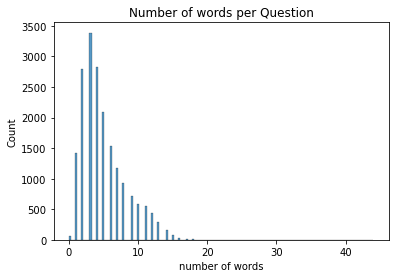

In [29]:
sns.histplot(combined_df['number of words']).set(title='Number of words per Question');

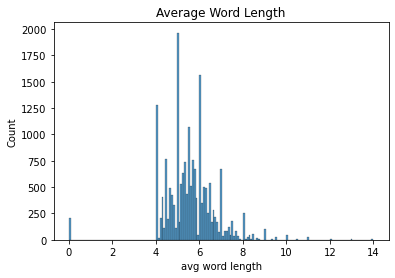

In [30]:
sns.histplot(combined_df['avg word length']).set(title='Average Word Length');

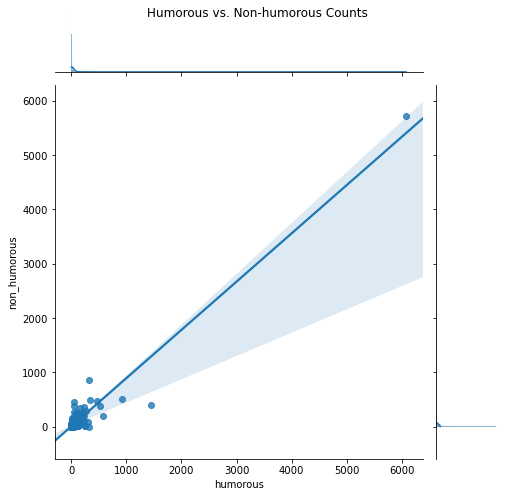

In [31]:
sns.jointplot(x="humorous", y="non_humorous", data=merged_words_df,
                  kind="reg", truncate=False, height=7).fig.suptitle("Humorous vs. Non-humorous Counts");

We see that the rare words* are possibly skewing the data. Let's remove that row and visualize again.

(rare words: words that appear only once out of all the words in the questions)

In [32]:
merged_words_df.drop([1808], inplace=True)

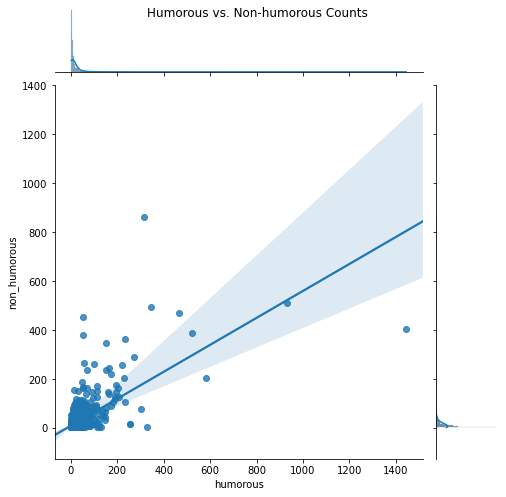

In [33]:
 #plot of humor/nonhumor raw counts zoomed in looking at correlation
 sns.jointplot(x="humorous", y="non_humorous", data=merged_words_df,
                  kind="reg", truncate=False, height=7).fig.suptitle("Humorous vs. Non-humorous Counts");

/Users/mattisonhineline/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


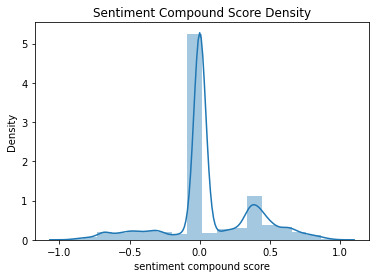

In [34]:
sns.distplot(combined_df['sentiment compound score'], bins=18).set_title('Sentiment Compound Score Density');

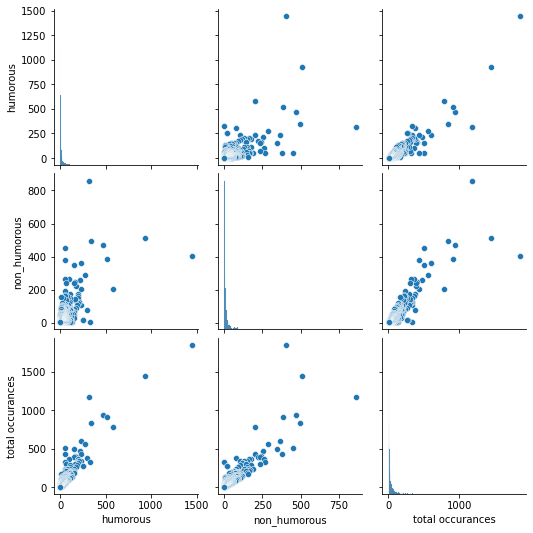

In [35]:
sns.pairplot(data=merged_words_df);

We see that indeed there might be some connection between the word and if the label is humorous or non_humorous!

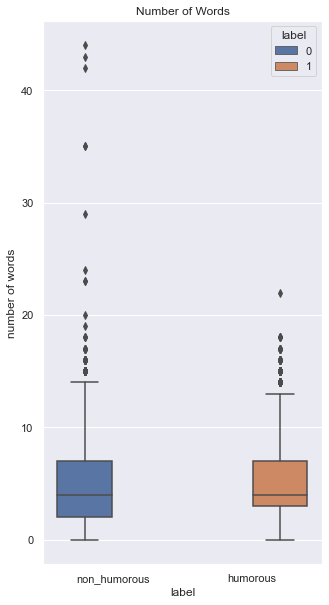

In [36]:
sns.set(rc = {'figure.figsize':(5,10)})

plot = sns.boxplot(data=combined_df, y="number of words", x='label', hue='label')
plot.set(title='Number of Words')
plot.set_xticklabels(['non_humorous', 'humorous']);

Great. Now we have a better idea how the data is distributed. We can also see which words are most frequently labeled as humorous or non_humorous

In [37]:
# print top 20 most common words in humorous
merged_words_df.sort_values(by=['humorous'], ascending=False).head(20)

,word,humorous,non_humorous,total occurances
0,will,1445,405,1850
14,come,930,512,1442
151,make,583,204,787
153,like,520,388,908
70,would,467,468,935
82,work,344,496,840
239,zombi,327,2,329
10,what,316,860,1176
74,help,301,78,379
73,need,274,288,562


In [38]:
# print top 20 most common words in non_humorous
merged_words_df.sort_values(by=['non_humorous'], ascending=False).head(20)

,word,humorous,non_humorous,total occurances
10,what,316,860,1176
14,come,930,512,1442
82,work,344,496,840
70,would,467,468,935
264,size,51,452,503
0,will,1445,405,1850
153,like,520,388,908
405,ship,54,379,433
16,product,234,364,598
91,made,152,348,500


______
## Evaluation and Modeling

As practice and for fun, we will try three models on this data. 
1. Multiple Linear Regression 
    1. We want to see if we can predict the word. For this we will first need to make the strings (words) usable in this model. For practice and curiosity, we will convert the words to bits then run the model.
2. KMeans Clustering
    1. We actually end up having to run Kmeans clustering twice to see if we can get a better model by adding in more features (word counts). 
3. Random Forest Regression Ensemble
    1. We also run a random forest regression, again for practice and for trying to find a better model. 

#### 1. Multiple Linear Regression
For the regression model, we will use the merged_words_df and try to predict the words.

In [39]:
lm = LinearRegression()
merged_words_df.columns

Index(['word', 'humorous', 'non_humorous', 'total occurances'], dtype='object')

In [40]:
# this function is thanks to a stackoverflow contributer here:
#  https://stackoverflow.com/questions/10237926/convert-string-to-list-of-bits-and-viceversa
#  which was contributed by John Gaines Jr. : https://stackoverflow.com/users/455506/john-gaines-jr

# make word strings to bits
def tobits(s):
    result = []
    for c in s:
        bits = bin(ord(c))[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])
    res = int("".join(map(str, result)))
    return res

Let's check our bit function.

In [41]:
print(tobits('hey'))
print('hey')

hey


In [42]:
#apply to all words
merged_words_df['bit words'] = merged_words_df['word'].apply(lambda row: tobits(row))

Lets set up the model with a 80-20 train-test split.

In [43]:
X = merged_words_df[['humorous', 'non_humorous']]
y = merged_words_df['bit words']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [45]:
lm.fit(X_train, y_train)

LinearRegression()

In [46]:
coeff_df = pd.DataFrame(lm.coef_ , X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
humorous,4.651606e+86
non_humorous,-8.216218e+88


Hmm, maybe using bits was not actually the best manner to do this project (which makes sense but it was worth a try). Let's plot it just in case to get a visual

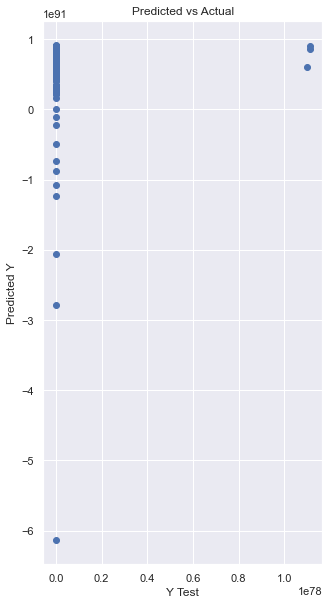

In [47]:
sns.set(rc = {'figure.figsize':(10,5)})

predictions = lm.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Predicted vs Actual');

/Users/mattisonhineline/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


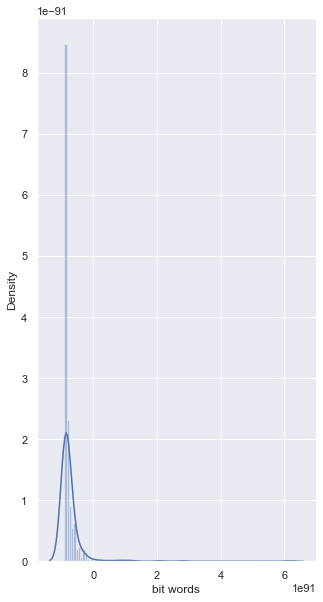

In [48]:
sns.distplot((y_test-predictions), bins=100);

In [49]:
print('MSE:', metrics.mean_squared_error(y_test, predictions))

MSE: 7.998765461696003e+181


This model is not convincing at this point. Let's move on to a clustering model.

#### 2a. K Means Unsupervised Clustering

For KMeans we know we have two clusters (humorous and non-humorous). Let's use our 'combined_df' dataframe to run kmeans and see what happens.

In [50]:
# set clusters
kmeans = KMeans(n_clusters=2)

In [51]:
kmeans_df = pd.DataFrame(combined_df, columns=['label', 'number of words', 'sentiment compound score', 'avg word length'])
kmeans_df.head(2)

,label,number of words,sentiment compound score,avg word length
0,1,4,0.0,6.25
1,1,4,0.0,7.50


In [52]:
# Let's fit the model
kmeans.fit(kmeans_df.drop('label', axis=1))
kmeans.cluster_centers_

array([[3.40786588, 0.0479562 , 5.49569805],
       [9.57882118, 0.13713013, 5.77080285]])

In [53]:
## evaluate bc we do happen to have the labels
print('Confusion Matrix')
print(confusion_matrix(kmeans_df['label'], kmeans.labels_))

Confusion Matrix
[[7053 2518]
 [7084 2487]]


In [54]:
print('Classification Report')
print(classification_report(kmeans_df['label'], kmeans.labels_))

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.74      0.59      9571
           1       0.50      0.26      0.34      9571

    accuracy                           0.50     19142
   macro avg       0.50      0.50      0.47     19142
weighted avg       0.50      0.50      0.47     19142



It seems our model is not able to classify the data into clean clusters very well. We are seeing precision and accuracy at only 50%, which is not very good. Let's visualize it to see what is happening.

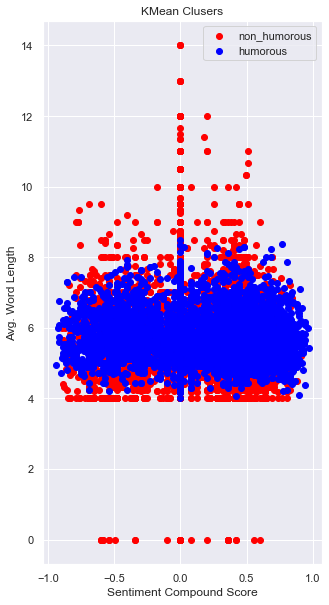

In [55]:
labels = kmeans.fit_predict(kmeans_df)
filtered_label0 = kmeans_df[labels == 0]
filtered_label1 = kmeans_df[labels == 1] 
plt.scatter(filtered_label0.iloc[:, 2],filtered_label0.iloc[:, 3], color = 'red', label = 'non_humorous')
plt.scatter(filtered_label1.iloc[:, 2],filtered_label1.iloc[:, 3], color = 'blue', label = 'humorous')
plt.legend()
plt.title('KMean Clusers')
plt.xlabel('Sentiment Compound Score')
plt.ylabel('Avg. Word Length');

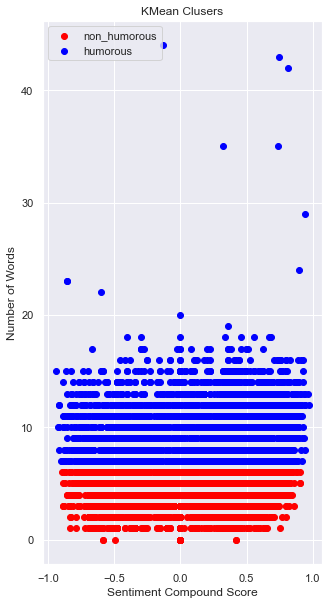

In [56]:
labels = kmeans.fit_predict(kmeans_df)
filtered_label0 = kmeans_df[labels == 0]
filtered_label1 = kmeans_df[labels == 1] 
plt.scatter(filtered_label0.iloc[:, 2],filtered_label0.iloc[:, 1], color = 'red', label = 'non_humorous')
plt.scatter(filtered_label1.iloc[:, 2],filtered_label1.iloc[:, 1], color = 'blue', label = 'humorous')
plt.legend()
plt.title('KMean Clusers')
plt.xlabel('Sentiment Compound Score')
plt.ylabel('Number of Words');

It seems like the model is not doing well in some respects but in others it is. Maybe it is actually better to plot this as a 3D shape. 

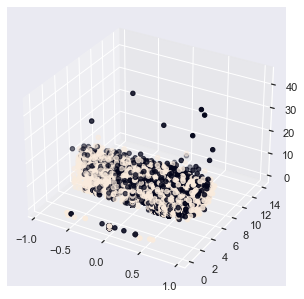

In [57]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = combined_df['sentiment compound score']
zdata = combined_df['number of words']
ydata = combined_df['avg word length']
ax.scatter3D(xdata, ydata, zdata, c=combined_df['label']);

Well that does not clarify the groups for us any more than before. Let's continue.

#### 2b. KMeans with more Features
take top 20 most frequent humorous and 20 most non_humorous. Add as columns to "combined". If they have that word in "clean > 3", column = 1, else = 0 

In [58]:
non_humorous_list = list(merged_words_df.sort_values(by=['non_humorous'], ascending=False).head(50)['word'])
humorous_list = list(merged_words_df.sort_values(by=['humorous'], ascending=False).head(50)['word'])
wordsList = non_humorous_list   #we will merge the two word-lists together
for word in humorous_list:
    if word not in wordsList:
        wordsList.append(word)

In [59]:
for word in wordsList:
    combined_df[word] = 0

In [60]:
for row in range(len(combined_df)):
    for word in combined_df.loc[row]['stemmed']: 
        if word in wordsList:
            combined_df.loc[row][word] += 1
        else: 
            pass

<ipython-input-60-2b7559fd6f75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df.loc[row][word] += 1


### Retry KMeans

Let's now take the top 20 humorous words and the top 20 non_humorous words and add them as columns to the 'combined_df' dataframe. After this we will put a counter for each time a word (column) appears in the question (row), the counter for that word in that row will increase by 1. We will use this for the model.

In [61]:
kmeans = KMeans(n_clusters=2)
kmeans_df = pd.DataFrame(combined_df, columns=['label', 'number of words', 
       'sentiment compound score', 'avg word length',
       'what', 'come', 'work', 'would', 'size', 'will', 'like', 'ship',
       'product', 'made', 'need', 'long', 'order', 'want', 'anyon', 'mani',
       'item', 'know', 'make', 'look', 'zombi', 'help', 'girl', 'kill', 'wear',
       'pictur', 'take', 'good', 'realli', 'thank', 'much', 'amazon', 'where',
       'price', 'differ', 'batteri', 'game', 'purchas', 'back', 'free', 'time',
       'actual', 'real', 'year', 'avail', 'could', 'color', 'small', 'light',
       'version', 'review', 'water', 'includ', 'blade', 'peopl', 'think',
       'give', 'power', 'life', 'turn', 'banana', 'wife', 'thing', 'hous',
       'becom', 'friend', 'watch', 'unicorn', 'enough', 'also', 'trump',
       'play']).copy()
kmeans_df.head(2)

,label,number of words,sentiment compound score,avg word length,what,come,work,would,size,will,...,thing,hous,becom,friend,watch,unicorn,enough,also,trump,play
0,1,4,0.0,6.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,1,4,0.0,7.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [62]:
kmeans_df.drop('play', axis=1, inplace=True)

In [63]:
kmeans.fit(kmeans_df.drop('label', axis=1))
kmeans.cluster_centers_

array([[9.57882118, 0.13713013, 5.77080285, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [64]:
print('confusion matrix')
print(confusion_matrix(kmeans_df['label'], kmeans.labels_))
print(classification_report(kmeans_df['label'], kmeans.labels_))

confusion matrix
[[2518 7053]
 [2487 7084]]
              precision    recall  f1-score   support

           0       0.50      0.26      0.35      9571
           1       0.50      0.74      0.60      9571

    accuracy                           0.50     19142
   macro avg       0.50      0.50      0.47     19142
weighted avg       0.50      0.50      0.47     19142



We got the almost the same results as before. Let's try an ensemble with Random Forest Regression

#### 3. Random Forest Regression Ensemble
Hopefully this model is able to run better than the others. We will use the new 'combined_df' for this model

In [65]:
labels_df = pd.DataFrame(combined_df, columns=['label', 
       'number of words', 'sentiment compound score', 'avg word length',
       'what', 'come', 'work', 'would', 'size', 'will', 'like', 'ship',
       'product', 'made', 'need', 'long', 'order', 'want', 'anyon', 'mani',
       'item', 'know', 'make', 'look', 'zombi', 'help', 'girl', 'kill', 'wear',
       'pictur', 'take', 'good', 'realli', 'thank', 'much', 'amazon', 'where',
       'price', 'differ', 'batteri', 'game', 'purchas', 'back', 'free', 'time',
       'actual', 'real', 'year', 'avail', 'could', 'color', 'small', 'light',
       'version', 'review', 'water', 'includ', 'blade', 'peopl', 'think',
       'give', 'power', 'life', 'turn', 'banana', 'wife', 'thing', 'hous',
       'becom', 'friend', 'watch', 'unicorn', 'enough', 'also', 'trump'])

0.5 is the median between 1 and 0 (humorous and non_humorous labels). Let's make a baseline to know if our model performs well.

In [66]:
labels_df['avg cat'] = .5

In [67]:
#set up predictions and features
predict_label = np.array(labels_df['label'])
labels_df.drop('label', axis = 1, inplace=True)

feature_list = list(labels_df.columns)
features_array = np.array(labels_df)

We will use a train-test split again for this model

In [68]:
train_x, test_x, train_y, test_y = train_test_split(features_array, predict_label, test_size = .2, random_state=101)

In [69]:
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

In [70]:
print('Training x', train_x.shape)
print('Training y', train_y.shape)
print('Test x', test_x.shape)
print('Test y', test_y.shape)

Training x (15313, 75)
Training y (15313,)
Test x (3829, 75)
Test y (3829,)


In [71]:
#set baseline, if cannot improve on baseline then this is not the right model for the dataset
baseline_predictions = test_x[:, feature_list.index('avg cat')]
baseline_errors = abs(baseline_predictions - test_y)

In [72]:
np.mean(baseline_errors)

0.501436406372421

In [74]:
ranForest = RandomForestRegressor(n_estimators=1000, random_state=101)
ranForest.fit(train_x, train_y)
predictions = ranForest.predict(test_x)
errors = abs(predictions - test_y)

In [75]:
# Mean Absolute Error 
print('MAE: ', round(np.mean(errors), 4), 'degrees.')

MAE:  0.4098 degrees.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
ranForest = RandomForestRegressor(n_estimators=1000, random_state=101)
ranForest.fit(train_x, train_y)
predictions = ranForest.predict(test_x)
errors = abs(predictions - test_y)

# Mean Absolute Error 
print('MAE: ', round(np.mean(errors), 4), 'degrees.')

MAE:  0.4541 degrees.


Our MAE is lower than our baseline, suggesting that the model does better than average. For now, we will accept this model.

Let's visualize one tree.

In [ ]:
#visualize the tree
estimator = ranForest.estimators_[20]
export_graphviz(estimator, 
                out_file='tree.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
from IPython.display import Image
Image(filename = 'tree.png')

# Fin